<a href="https://colab.research.google.com/github/Navya130/internship-project/blob/main/weather_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from google.colab import files
import io
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
uploaded = files.upload()

Saving Turbine_Data.csv to Turbine_Data.csv


In [3]:
uploaded = files.upload()

Saving Project 1 - Weather Dataset.csv to Project 1 - Weather Dataset.csv


In [5]:
df = pd.read_csv('Turbine_Data.csv')

In [6]:
df.rename(columns={'Unnamed: 0': 'Timestamp'}, inplace=True)
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Drop rows where the target 'ActivePower' is missing
df = df.dropna(subset=['ActivePower'])

In [7]:
key_features = ['WindSpeed', 'WindDirection', 'AmbientTemperatue']
for col in key_features:
    # Filling missing values with the median to avoid outlier distortion
    df[col] = df[col].fillna(df[col].median())


In [8]:
df['WindDir_sin'] = np.sin(np.radians(df['WindDirection']))
df['WindDir_cos'] = np.cos(np.radians(df['WindDirection']))

# B. Time-based Features
df['Hour'] = df['Timestamp'].dt.hour
df['Month'] = df['Timestamp'].dt.month

# C. Filter Noise
# Remove data where ActivePower is negative (sensor errors)
df = df[df['ActivePower'] >= 0]


In [9]:
final_columns = ['ActivePower', 'WindSpeed', 'AmbientTemperatue',
                 'WindDir_sin', 'WindDir_cos', 'Hour', 'Month']
processed_df = df[final_columns]

In [10]:
processed_df.to_csv('Cleaned_Turbine_Data.csv', index=False)
files.download('Cleaned_Turbine_Data.csv')

print("Preprocessing Complete! Cleaned_Turbine_Data.csv is ready for modeling.")
print(processed_df.head())

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Preprocessing Complete! Cleaned_Turbine_Data.csv is ready for modeling.
     ActivePower  WindSpeed  AmbientTemperatue  WindDir_sin  WindDir_cos  \
182    26.212347   3.042750          28.696304    -0.951057    -0.309017   
184    59.632658   3.424814          29.052567    -0.965926    -0.258819   
185    40.889650   3.507172          28.984758    -0.995805    -0.091502   
208    34.398111   3.442212          30.282058    -0.971342     0.237686   
216    29.797653   3.031363          29.333519    -0.997564     0.069756   

     Hour  Month  
182     6      1  
184     6      1  
185     6      1  
208    10      1  
216    12      1  


In [11]:
features = [
    'WindSpeed',
    'AmbientTemperatue',
    'WindDir_sin',
    'WindDir_cos',
    'Hour'
]

X = df[features]

In [12]:
y = df['ActivePower']

print("Features selected for model training:")
print(X.columns.tolist())
print(f"\nShape of Feature Matrix: {X.shape}")
print(f"Shape of Target Vector: {y.shape}")


Features selected for model training:
['WindSpeed', 'AmbientTemperatue', 'WindDir_sin', 'WindDir_cos', 'Hour']

Shape of Feature Matrix: (79106, 5)
Shape of Target Vector: (79106,)


In [13]:
X.head()

,WindSpeed,AmbientTemperatue,WindDir_sin,WindDir_cos,Hour
182,3.042750,28.696304,-0.951057,-0.309017,6
184,3.424814,29.052567,-0.965926,-0.258819,6
185,3.507172,28.984758,-0.995805,-0.091502,6
208,3.442212,30.282058,-0.971342,0.237686,10
216,3.031363,29.333519,-0.997564,0.069756,12


In [14]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Training features shape: {X_train.shape}")
print(f"Testing features shape: {X_test.shape}")

Training features shape: (63284, 5)
Testing features shape: (15822, 5)


In [15]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [16]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [17]:
y_pred = rf_model.predict(X_test)

# 3. Evaluate Performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"Model Results:\nRMSE: {rmse:.2f} kW\nR2 Score: {r2:.4f}")

Model Results:
RMSE: 74.92 kW
R2 Score: 0.9842


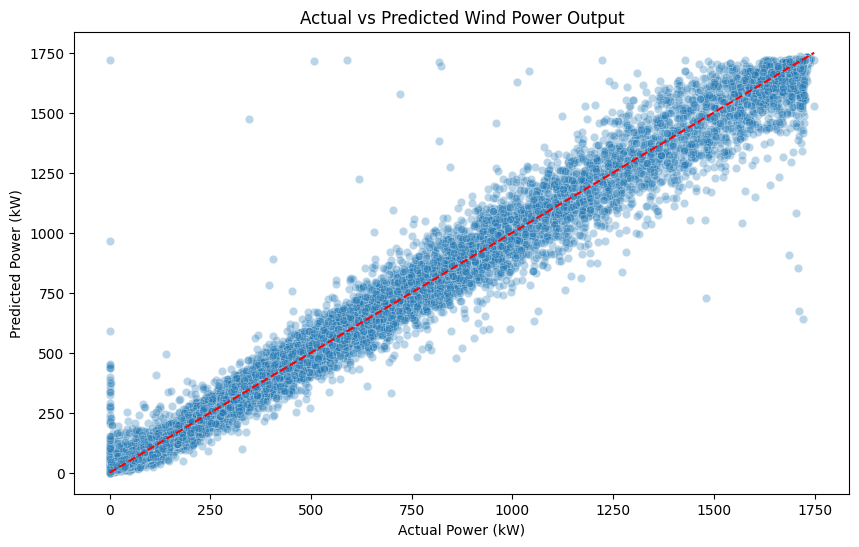

In [18]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.3)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted Wind Power Output')
plt.xlabel('Actual Power (kW)')
plt.ylabel('Predicted Power (kW)')
plt.show()

In [26]:
def predict_energy(wind_speed, temp, direction_deg, hour):
  sin_dir = np.sin(np.radians(direction_deg))
  cos_dir = np.cos(np.radians(direction_deg))
  input_data = pd.DataFrame([[wind_speed, temp, sin_dir, cos_dir, hour]],
                              columns=['WindSpeed', 'AmbientTemperatue', 'WindDir_sin', 'WindDir_cos', 'Hour'])
  prediction = rf_model.predict(input_data)
  return prediction[0]

In [27]:
# Example usage of the predict_energy function

wind_speed = 5.0  # Example wind speed in m/s
temp = 25.0       # Example ambient temperature in Celsius
direction_deg = 180.0 # Example wind direction in degrees (South)
hour = 14         # Example hour of the day (2 PM)

predicted_power = predict_energy(wind_speed, temp, direction_deg, hour)
print(f"Predicted Active Power: {predicted_power:.2f} kW")

Predicted Active Power: 265.36 kW


In [28]:
my_wind_speed = 10.5 # m/s
my_temp = 22.0       # Celsius
my_direction = 180   # South
my_hour = 14         # 2 PM

output = predict_energy(my_wind_speed, my_temp, my_direction, my_hour)
print(f"Predicted Energy Output: {output:.2f} kW")

Predicted Energy Output: 1718.07 kW
